* install openAi version of clip API

In [1]:
!pip install openai-clip

In [2]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
from torch import nn
from torchvision.transforms import Compose, Resize, ToTensor
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import torch.optim as optim
from tqdm.autonotebook import tqdm
from collections import OrderedDict
import torch.nn.functional as F
from torch.optim import lr_scheduler
import netron
import torch.onnx
from torch.autograd import Variable
_tokenizer = _Tokenizer()

/var/folders/pn/q7mmpvpx5n36lk_j6p9gqk4c0000gn/T/ipykernel_56519/1017408313.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
model, preprocess = clip.load('ViT-B/32', device)

## Performance Test over zero-shot

In [21]:

from tqdm import tqdm
cifar100 = CIFAR100(root=os.path.join(os.getcwd(), 'dataset'), download=True, train=False)
def evaluate_model(cifar100):
    correct = 0
    total = len(cifar100)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    print(f'text_features:\n{text_features.shape}')
    with torch.no_grad(), tqdm(total=len(cifar100)) as pbar:
        for i in range(len(cifar100)):
            image, class_id = cifar100[i]
            image = image
            image_input = preprocess(image).unsqueeze(0).to(device)
            with torch.no_grad():
                image_features = model.encode_image(image_input)
            image_features /= image_features.norm(dim=-1, keepdim=True).to(device)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity[0].topk(1)
            if indices[0] == class_id:
                correct += 1
            pbar.update(1)  #
            if i % 1000 == 0:
                pbar.set_description(f"Accuracy: {correct / (i + 1) * 100:.2f}%")
    print(f'before CoOp acc: {correct / total * 100:.2f}% ')
    return correct / total * 100


In [1]:
acc = evaluate_model(cifar100)
print(f'acc is {acc} %')

acc is 61.62 %


* It can be found that although there is a certain zeroshot ability, but not before the fine-tuning of a particular dataset his understanding is limited, for complex backgrounds or environments of the picture text2live limited ability to manipulate the root of the model to contact the input text and the corresponding picture of the semantics of the ability to limited

* load the cifar100 dataset to test the network performance

In [6]:
cifar100_data = CIFAR100(root=os.path.join(os.getcwd(), 'dataset'), train=False, transform=preprocess,download=True)

Files already downloaded and verified


In [22]:
ctx_init = 'a photo_of a'
ctx_init = ctx_init.replace("_", " ")
n_ctx = len(ctx_init.split(" "))
prompt_prefix = ctx_init
print(f'Initial context: "{prompt_prefix}"')
print(f"Number of context words (tokens): {n_ctx}")

Initial context: "a photo of a"
Number of context words (tokens): 4


## Define the vector from the word embedding of the whole sentence
* 100 is for 100 type of classes
* 77 is embedded 'a photo of a {class}'
* 512 is dimension of the word embeddeding
* since we want to construct $[v_1(x)][v_2(x)][v_3(x)][v_4(x)]{class} $, which means first four places required grad and the last one is the class should be static. This means we will get the prompt embedding automatically to let our model have the best understand the text and image.
* $[v_1(x)][v_2(x)][v_3(x)][v_4(x)]{class} $ here x is the image embedding after preprocessing, we want our network combine both image information and text in the dataset
* the following part, we only get the context words trainable (here is 'a photo of a' and length is 4), we will make automatic calculation base on that.

In [ ]:
def get_tokens(prompt_prefix:str,  classnames:list):
  classnames = [name.replace("_", " ") for name in classnames]
  name_lens = [len(_tokenizer.encode(name)) for name in classnames]
  prompts = [prompt_prefix + " " + name + "." for name in classnames]

  tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)  # (n_cls, n_tkn)
  with torch.no_grad():
    embedding = model.token_embedding(tokenized_prompts).type(model.dtype)  # (n_cls, n_tkn, dim)

  token_prefix = nn.Parameter(embedding[:, :1, :], requires_grad=False).to(device)  # (n_cls, 1, dim)
  token_suffix = nn.Parameter(embedding[:, 1 + n_ctx:, :], requires_grad=False).to(device)  # (n_cls, 1, dim)
  trainable_hidden_state = nn.Parameter(embedding[:, 1:1 + n_ctx,:].clone(),requires_grad=True).to(device)
  return token_prefix, token_suffix, tokenized_prompts, trainable_hidden_state

In [ ]:
token_prefix, token_suffix, tokenized_prompts, trainable_hidden_state = get_tokens(prompt_prefix, cifar100_data.classes)

* define the subnet to capture the features of the input image information to help to construct the prompt text

In [32]:
class MetaNet(nn.Module):
    def __init__(self, net):
        super(MetaNet, self).__init__()
        self.net = net

    def forward(self, x):
        return self.net(x)

vis_dim = model.visual.output_dim # 512
ctx_dim = model.ln_final.weight.shape[0] # 512

meta_net = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(vis_dim, vis_dim // 16)),
            ("relu", nn.ReLU(inplace=True)),
            ("linear2", nn.Linear(vis_dim // 16, ctx_dim))
        ])).type(model.dtype).to(device)
meta_net = MetaNet(meta_net).type(model.dtype).to(device)


In [ ]:
def construct_prompts(im_features,token_prefix,token_suffix,trainable_hidden_state,len_classes):

  bias = meta_net(im_features).to(device) # (batch, ctx_dim)

  bias = bias.unsqueeze(1).to(device)   # (batch, 1, ctx_dim) 16,1,512
  
  trainable_hidden_state = trainable_hidden_state.mean(dim=0, keepdim=True) # 
  trainable_hidden_state_shifted = trainable_hidden_state + bias           
  
  prompts = []
  for hidden_shifted_i in trainable_hidden_state_shifted:
      hid_i = hidden_shifted_i.unsqueeze(0).expand(len_classes, -1, -1)
      pts_i = torch.cat((token_prefix, hid_i, token_suffix),dim=1)
      prompts.append(pts_i)
  prompts = torch.stack(prompts).to(device)
  return prompts

* define tools
* text_encoder to encode the prompt to add positional information there

In [ ]:
def text_encoder(prompt_all,tokenized_prompts):
  x = prompt_all + model.positional_embedding.type(model.dtype)
  x = x.permute(1, 0, 2)  # NLD -> LND
  x = model.transformer(x)
  x = x.permute(1, 0, 2)  # LND -> NLD
  x = model.ln_final(x).type(model.dtype)

  # take features from the eot embedding (eot_token is the highest number in each sequence)
  x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ model.text_projection
  return x

* Define the analytical metrics
    * this will calculate the accumulated loss in each epoch

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


* define forward propagation
    * use image feature and text to build prompt template 
    * find the prompt template that can maximize the similarity between the text and image

In [ ]:
def forward_(images_batch, labels_batch=None):
    image_features = model.encode_image(images_batch)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features = image_features / image_features_norm
    prompt_all = construct_prompts(image_features,token_prefix,token_suffix,trainable_hidden_state,len(cifar100_data.classes))
    similarity_list = []
    for pts_i, imf_i in zip(prompt_all,image_features):
        text_features = text_encoder(pts_i,tokenized_prompts)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        similarity_list.append(similarity)
    similarity_list = torch.stack(similarity_list)
    if model.train and labels_batch!=None:
        return F.cross_entropy(similarity_list.mean(dim=0), labels_batch)
    else:
        return similarity_list

* use CosineAnnealingLR to adjust the learning rate every 2 epoch automatically
* $\begin{align}\eta_{t}=\eta_{m i n}+\frac{1}{2}(\eta_{m a x}-\eta_{m i n})\left(1+\cos\left(\frac{T_{c u r}}{T_{m a x}}\pi\right)\right),\ \ \ T_{c u r}\neq(2k+1)T_{m a x};\end{align}$
* $\begin{align}\eta_{t+1}=\eta_{t}+\frac{1}{2}(\eta_{m a x}-\eta_{m i n})\left(1-\cos\left(\frac{1}{T_{m a x}}\pi\right)\right),\qquad T_{c u r}=(2k+1)T_{m a x}.\end{align}$
* $ \begin{align}\eta_{t}=\eta_{m i n}+\frac{1}{2}(\eta_{m a x}-\eta_{m i n})\left(1+\cos\left(\frac{T_{c u r}}{T_{m a x}}\pi\right)\right)\end{align}$

In [ ]:
optimizer = optim.SGD(list(meta_net.parameters()) + [trainable_hidden_state], lr=0.0001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)

In [ ]:
dataloader = torch.utils.data.DataLoader(cifar100_data, batch_size=16, shuffle=True)
num_of_epoch = 20
for epoch in range(num_of_epoch):
    model.train()
    scheduler.step()
    avg_loss = AvgMeter()
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_of_epoch}')
    for images_batch, labels_batch in progress_bar:
        images_batch = images_batch.to(device) # [batch_size, 3, 224, 224]
        labels_batch = labels_batch.to(device)

        loss = forward_(images_batch, labels_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss.update(loss.item())
        progress_bar.set_postfix({'loss': avg_loss.avg})
    torch.save(meta_net.state_dict(), f'models/meta_net_{epoch+1}.pth')
    torch.save(trainable_hidden_state, f'models/trainable_hidden_state_{epoch+1}.pth')
    progress_bar.close()
  #     pbar.update(1)
    print('Epoch:', epoch+1, 'Loss:', avg_loss.avg)

## Analyze

In [41]:
meta_net = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(vis_dim, vis_dim // 16)),
            ("relu", nn.ReLU(inplace=True)),
            ("linear2", nn.Linear(vis_dim // 16, ctx_dim))
        ])).type(model.dtype).to(device)
meta_net = MetaNet(meta_net).type(model.dtype).to(device)

device = torch.device('cpu')
meta_net.load_state_dict(torch.load('models/meta_net_13.pth',map_location=torch.device('cpu')))
trainable_hidden_state = torch.load('models/trainable_hidden_state_13.pth',map_location=torch.device('cpu'))
if trainable_hidden_state.device != device:
    trainable_hidden_state = trainable_hidden_state.to(device)  # 
meta_net.to(device)

MetaNet(
  (net): Sequential(
    (linear1): Linear(in_features=512, out_features=32, bias=True)
    (relu): ReLU(inplace=True)
    (linear2): Linear(in_features=32, out_features=512, bias=True)
  )
)

* after train test the zero shot performance

In [56]:
def zeroshot_evalution(model,dataset):
    model.eval()
    dataloader_for_evalution = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    correct = 0
    total = 0
    
    with torch.no_grad(), tqdm(total=len(dataloader_for_evalution)) as pbar:
        for images_batch, labels_batch in dataloader_for_evalution:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            similarity_list = forward_(images_batch)
            similarity = similarity_list.mean(dim=0)
            predicted_labels = similarity.argmax( dim=-1)
            correct += (predicted_labels == labels_batch).sum().item()
            total += labels_batch.size(0)
            pbar.update(1)
    accuracy = correct / total * 100
    return accuracy

In [58]:
accuracy = zeroshot_evalution(model,cifar100_data)

print(f'acc is {accuracy} %')


acc is 70.01 %


## Interpreting the learned prompts
* using L1 distance between trained embedding and word table
* The L1 distance is used to measure the similarity between the output and the cue. A smaller L1 distance indicates that the output is closer to the corresponding cue, while a larger L1 distance indicates a larger difference between the output and the cue.

In [ ]:
import torch

from clip.simple_tokenizer import SimpleTokenizer
from clip import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# prompts = trainable_hidden_state
prompts = torch.load('/kaggle/input/coop10/trainable_hidden_state.pth')
topk = 3
tokenizer = SimpleTokenizer()
token_embedding = model.token_embedding.weight
print(f"Size of token embedding: {token_embedding.shape}")


In [119]:
import numpy as np

for i in range(prompts.shape[1]):
    
    word_i = prompts[:,i,:].mean(dim=0)
    distance = torch.cdist(word_i.type(model.dtype).unsqueeze(0), token_embedding.type(model.dtype))
    sorted_idxs = torch.argsort(distance, dim=1)
    sorted_idxs = sorted_idxs[:, :topk]
    for m, idxs in enumerate(sorted_idxs):
        
        words = [tokenizer.decoder[idx.item()] for idx in idxs]
        dist = [f"{distance[m, idx].item():.4f}" for idx in idxs]
        score = ([-np.log(float(d)) for (d) in dist])
        print(f"words: {words}\t score:{score}\t distance: {dist}")


words: ['a</w>', 'an</w>', '0']	 score:[3.139602643973693, 1.658628156624872, 1.3943265328171548]	 distance: ['0.0433', '0.1904', '0.2480']
words: ['photo</w>', 'photos</w>', 'pic</w>']	 score:[3.116770601931047, 1.373575588712116, 1.3582901647102932]	 distance: ['0.0443', '0.2532', '0.2571']
words: ['of</w>', '0', '1']	 score:[2.2643263808769554, 1.3795173768408668, 1.3795173768408668]	 distance: ['0.1039', '0.2517', '0.2517']
words: ['a</w>', 'an</w>', '0']	 score:[2.7473109150555124, 1.6357818877737023, 1.4085399700672103]	 distance: ['0.0641', '0.1948', '0.2445']



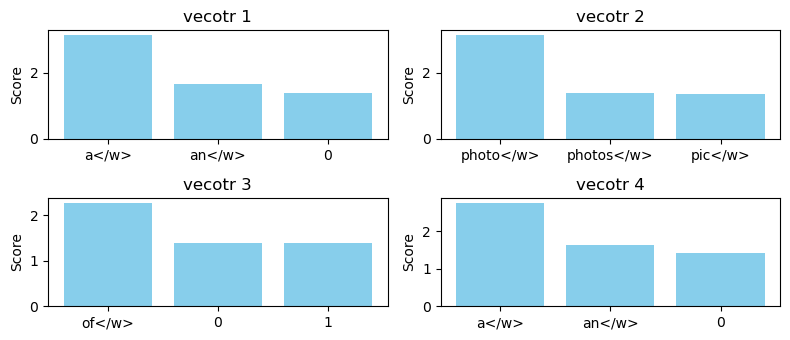

In [118]:
data = {
    'vecotr 1': {'words': ['a</w>', 'an</w>', '0'], 'scores': [3.139602643973693, 1.658628156624872, 1.3943265328171548]},
    'vecotr 2': {'words': ['photo</w>', 'photos</w>', 'pic</w>'], 'scores': [3.116770601931047, 1.373575588712116, 1.3582901647102932]},
    'vecotr 3': {'words': ['of</w>', '0', '1'], 'scores': [2.2643263808769554, 1.3795173768408668, 1.3795173768408668]},
    'vecotr 4': {'words': ['a</w>', 'an</w>', '0'], 'scores': [2.7473109150555124, 1.6357818877737023, 1.4085399700672103]}
}

import matplotlib.pyplot as plt

labels = list(data.keys())
word_lists = [data[label]['words'] for label in labels]
scores_lists = [data[label]['scores'] for label in labels]

fig, axes = plt.subplots(2, 2, figsize=(8, 3.5))

for i, ax in enumerate(axes.flatten()):
    word_list = word_lists[i]
    scores_list = scores_lists[i]
    x = range(len(word_list))
    ax.bar(x, scores_list, color='skyblue')
    ax.set_xticks(x)
    ax.set_xticklabels(word_list)
    ax.set_title(labels[i])
    ax.set_ylabel('Score')

plt.tight_layout()
plt.show()


* The -log of the distance of the two embedding is defined as socre, and the higher the score, the closer the word is to the trained prompt word. I calculated and output top3 similar words, I can find that the output is still a black box, the highest is plus garbled English.

* visualization

In [86]:
modelData = "./meta_net.pth"  # 
batch_size = 16
dim = model.visual.output_dim # 512
x = torch.randn(batch_size, dim)  
torch.onnx.export(meta_net, x, modelData)  
netron.start(modelData)  # 

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Serving './meta_net.pth' at http://localhost:21107


('localhost', 21107)

* 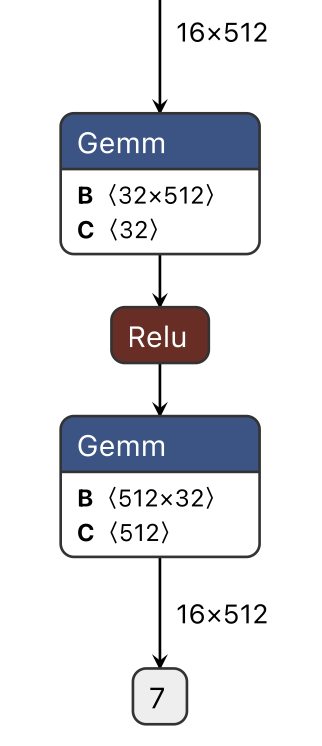